In [1]:
import os
import sys
import json
from pathlib import Path
from typing import Union

sys.path.insert(0, str(Path(os.getcwd()).parent.parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from src.data_analysis.model_training import (
    get_device_helper,
    get_fashion_mnist_data_sets
)
from src.data_analysis.model_evaluation import feature_maps_viz_runner
from src.data_analysis.fully_connected_network import ACAIGFCN
from src.data_analysis.mnist_constants import FASHION_MNIST_INPUT_DIM, FASHION_MNIST_OUTPUT_DIM
from src.data_analysis.custom_cnn import MyFirstCNN, MySecondCNN
from src.common.file_io_helper import incriment_file

VISUALS_DIR = 'visualizations'
CUTOVER_EXPERIMENT = 43
ODD_EXPERIMENT = 44
ODD_EXPERIMENT_CONV_OUT_LAYERS = [16, 32, 64]
MODEL_EXPERIMENT_FILEPATH = 'experiments/models/experiment_number_{:04d}.pth'
EXPERIMENT_FILEPATH = 'experiments/experiments.json'

In [13]:
hidden_layer_dims = {
    59: [64, 32],
    60: [128, 64],
    61: [220, 128],
}

FCN_ARCHITECTURE = {
    "input_dim": FASHION_MNIST_INPUT_DIM,
    "output_dim": FASHION_MNIST_OUTPUT_DIM,
    "activation_function": torch.nn.functional.relu,
    "dropout": [0.5, 0.5],
    "batch_norm": True,
}

{'input_dim': 784,
 'output_dim': 10,
 'activation_function': <function torch.nn.functional.relu(input: torch.Tensor, inplace: bool = False) -> torch.Tensor>,
 'dropout': [0.5, 0.5],
 'batch_norm': True,
 'hidden_layer_dims': [64, 32]}

In [14]:
def load_model(experiment_number: int, exp_df: pd.DataFrame) -> torch.nn.Module:
    model_type = exp_df.loc[[experiment_number]]['model_type'].iloc[0]
    if model_type == "FCN":
        FCN_ARCHITECTURE.update({"hidden_layer_dims": hidden_layer_dims[experiment_number]})
        model = ACAIGFCN(
            **FCN_ARCHITECTURE
        )
    else:
        if experiment_number < ODD_EXPERIMENT:
            model = MyFirstCNN()
        elif experiment_number == ODD_EXPERIMENT:
            model = MySecondCNN(out_channels_list=ODD_EXPERIMENT_CONV_OUT_LAYERS)
        else:
            conv_out_channels_series = exp_df.loc[[experiment_number]]['conv_out_channels_list']
            if not conv_out_channels_series.isna().iloc[0]:
                out_channels_list = conv_out_channels_series.iloc[0]
            else:
                out_channels_list = None
            model = MySecondCNN(out_channels_list=out_channels_list)

    model_dict_and_metadata = torch.load(MODEL_EXPERIMENT_FILEPATH.format(experiment_number + 1), weights_only=False)
    model_state_dict = model_dict_and_metadata["model_state_dict"]
    model_dict_and_metadata.pop("model_state_dict")
    model.load_state_dict(model_state_dict)
    return model, model_dict_and_metadata


def plot_model_results(model_metadata: Union[dict, list[dict]], experiments: list[int], savefig: bool = True):
    if not model_metadata:
        raise ValueError('No model metadata provided')

    if isinstance(model_metadata, dict):
        model_metadata = [model_metadata]
    fig = plt.figure(figsize=(12, 8), dpi=100)
    ax0 = fig.add_subplot(221)
    ax1 = fig.add_subplot(222)
    ax2 = fig.add_subplot(223)
    ax3 = fig.add_subplot(224)
    
    for experiment_no, metadata in zip(experiments, model_metadata):
        label=f'Exp No. {experiment_no} (Test Acc: {metadata["mean_test_accuracy"]:.4f})'
        ax0.plot(metadata['train_loss'], label=label, alpha=0.65)
        ax2.plot(np.array(metadata['validation_loss'])[:,0], np.array(metadata['validation_loss'])[:,1], label=label)

        ax1.plot(metadata['train_accuracy'], label=label, alpha=0.65)
        ax3.plot(np.array(metadata['validation_accuracy'])[:,0], np.array(metadata['validation_accuracy'])[:,1], label=label)

    ax0.legend()
    ax1.legend()
    ax2.legend()
    ax3.legend()

    ax0.set_title('Training Loss')
    ax1.set_title('Training Accuracy')
    ax2.set_title('Validation Loss')
    ax3.set_title('Validation Accuracy')

    plt.suptitle('Model Training Results')
    plt.tight_layout()

    if savefig:
        if not os.path.exists(VISUALS_DIR):
            os.mkdir(VISUALS_DIR)
        filename = incriment_file('model_training_results_vis.png', VISUALS_DIR)
        plt.savefig(filename)
    plt.show()


def gather_metadata(
    experiments: list[int],
    experiments_df: pd.DataFrame,
) -> tuple[list[torch.nn.Module], list[dict]]:
    model_metadata = []
    models = []
    for i in experiments:
        model, metadata = load_model(i, experiments_df)
        model_metadata.append(metadata)
        models.append(model)
    return models, model_metadata


In [15]:
with open(EXPERIMENT_FILEPATH, 'r') as file:
    records = json.load(file)
    experiment_results_df = pd.DataFrame.from_records(records)

experiment_results_df.tail()

,model_type,num_epochs,total_num_weights,training_time,optimizer,learning_rate,optimizer_hyperparams,weight_init,mean_test_accuracy,std_test_accuracy,model_architecture,conv_out_channels_list
57,CNN,50,20071,0:04:15,Adam,0.001,"{'betas': [0.9, 0.999]}",xavier_uniform,0.909082,0.015103,MySecondCNN,"[8, 15, 30]"
58,CNN,50,50392,0:05:19,Adam,0.001,"{'betas': [0.9, 0.999]}",xavier_uniform,0.915234,0.018819,MySecondCNN,"[16, 30, 60]"
59,FCN,50,52842,0:02:30,Adam,0.001,"{'betas': [0.9, 0.999]}",kaiming_uniform,0.880176,0.015780,NaN,NaN
60,FCN,50,109770,0:02:32,Adam,0.001,"{'betas': [0.9, 0.999]}",kaiming_uniform,0.888867,0.021089,NaN,NaN
61,FCN,50,202974,0:02:32,Adam,0.001,"{'betas': [0.9, 0.999]}",kaiming_uniform,0.896484,0.018835,NaN,NaN


In [16]:
experiment_results_df[experiment_results_df["model_type"] == "FCN"]

,model_type,num_epochs,total_num_weights,training_time,optimizer,learning_rate,optimizer_hyperparams,weight_init,mean_test_accuracy,std_test_accuracy,model_architecture,conv_out_channels_list
0,FCN,40,202974,0:02:01,Adam,0.001,"{'betas': [0.9, 0.999]}",kaiming_uniform,0.895508,0.019990,NaN,NaN
1,FCN,40,52842,0:02:02,Adam,0.001,"{'betas': [0.9, 0.999]}",kaiming_uniform,0.874121,0.023960,NaN,NaN
2,FCN,40,109770,0:02:04,Adam,0.001,"{'betas': [0.9, 0.999]}",kaiming_uniform,0.884863,0.016200,NaN,NaN
59,FCN,50,52842,0:02:30,Adam,0.001,"{'betas': [0.9, 0.999]}",kaiming_uniform,0.880176,0.015780,NaN,NaN
60,FCN,50,109770,0:02:32,Adam,0.001,"{'betas': [0.9, 0.999]}",kaiming_uniform,0.888867,0.021089,NaN,NaN
61,FCN,50,202974,0:02:32,Adam,0.001,"{'betas': [0.9, 0.999]}",kaiming_uniform,0.896484,0.018835,NaN,NaN


In [17]:
experiment_results_df.tail(6)

,model_type,num_epochs,total_num_weights,training_time,optimizer,learning_rate,optimizer_hyperparams,weight_init,mean_test_accuracy,std_test_accuracy,model_architecture,conv_out_channels_list
56,CNN,50,9980,0:04:02,Adam,0.001,"{'betas': [0.9, 0.999]}",xavier_uniform,0.900195,0.022877,MySecondCNN,"[6, 10, 16]"
57,CNN,50,20071,0:04:15,Adam,0.001,"{'betas': [0.9, 0.999]}",xavier_uniform,0.909082,0.015103,MySecondCNN,"[8, 15, 30]"
58,CNN,50,50392,0:05:19,Adam,0.001,"{'betas': [0.9, 0.999]}",xavier_uniform,0.915234,0.018819,MySecondCNN,"[16, 30, 60]"
59,FCN,50,52842,0:02:30,Adam,0.001,"{'betas': [0.9, 0.999]}",kaiming_uniform,0.880176,0.015780,NaN,NaN
60,FCN,50,109770,0:02:32,Adam,0.001,"{'betas': [0.9, 0.999]}",kaiming_uniform,0.888867,0.021089,NaN,NaN
61,FCN,50,202974,0:02:32,Adam,0.001,"{'betas': [0.9, 0.999]}",kaiming_uniform,0.896484,0.018835,NaN,NaN


In [18]:
experiment_results_df[
    experiment_results_df.model_type == "CNN"
][
    ["weight_init", "mean_test_accuracy", "std_test_accuracy"]
].groupby("weight_init").agg(["mean", "std"])

mean_test_accuracy           std_test_accuracy          
                              mean       std              mean       std
weight_init                                                             
kaiming_uniform           0.814155  0.253134          0.021483  0.005936
random_normal             0.752384  0.301675          0.022235  0.004606
xavier_uniform            0.907820  0.022206          0.019354  0.003366

In [19]:
experiment_results_df.loc[experiment_results_df[experiment_results_df["num_epochs"] == 50]["mean_test_accuracy"].idxmax()]

model_type                                    CNN
num_epochs                                     50
total_num_weights                          108814
training_time                             0:06:15
optimizer                                    Adam
learning_rate                               0.001
optimizer_hyperparams     {'betas': [0.9, 0.999]}
weight_init                        xavier_uniform
mean_test_accuracy                       0.923633
std_test_accuracy                        0.016663
model_architecture                    MySecondCNN
conv_out_channels_list                        NaN
Name: 49, dtype: object

In [20]:
experiment_results_df.iloc[[49]]

,model_type,num_epochs,total_num_weights,training_time,optimizer,learning_rate,optimizer_hyperparams,weight_init,mean_test_accuracy,std_test_accuracy,model_architecture,conv_out_channels_list
49,CNN,50,108814,0:06:15,Adam,0.001,"{'betas': [0.9, 0.999]}",xavier_uniform,0.923633,0.016663,MySecondCNN,NaN


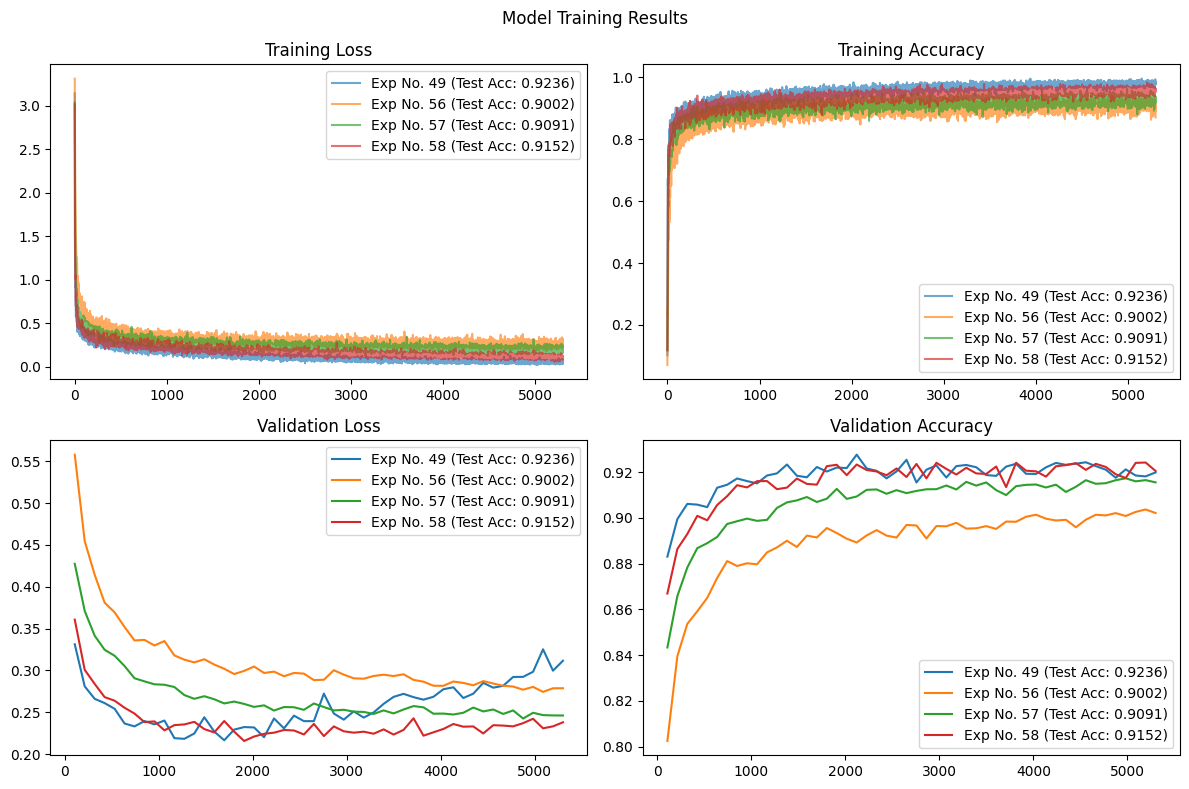

In [24]:
exps = [49, 56, 57, 58]

models, model_metadata_list = gather_metadata(exps, experiments_df=experiment_results_df)

plot_model_results(
    model_metadata_list,
    exps,
    savefig=True,
)

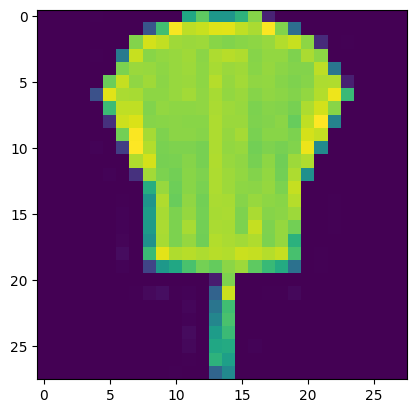

In [133]:
train_dataset, test_dataset = get_fashion_mnist_data_sets()
device = get_device_helper()

plt.imshow(train_dataset.data[56], cmap="viridis")
plt.show()

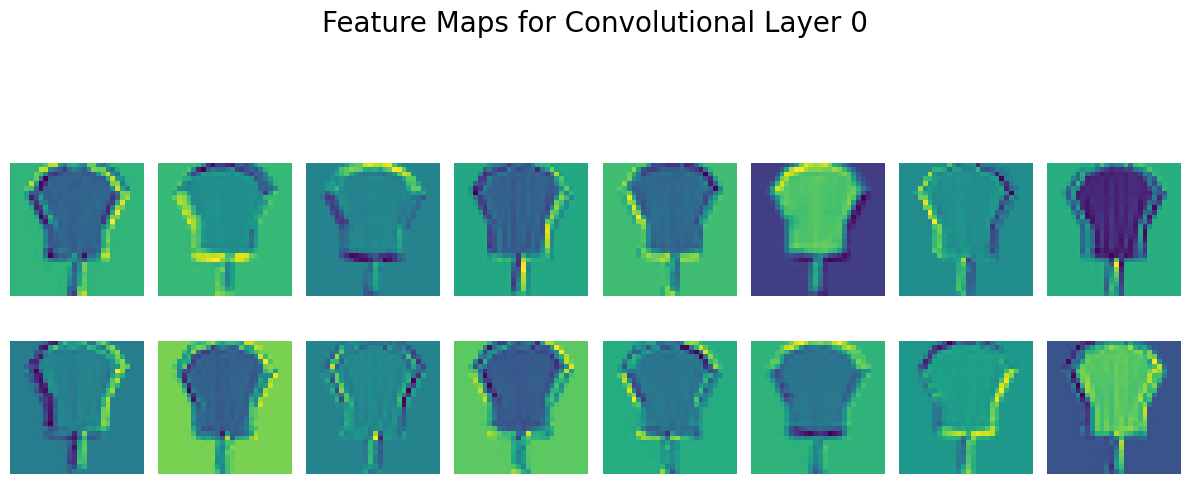

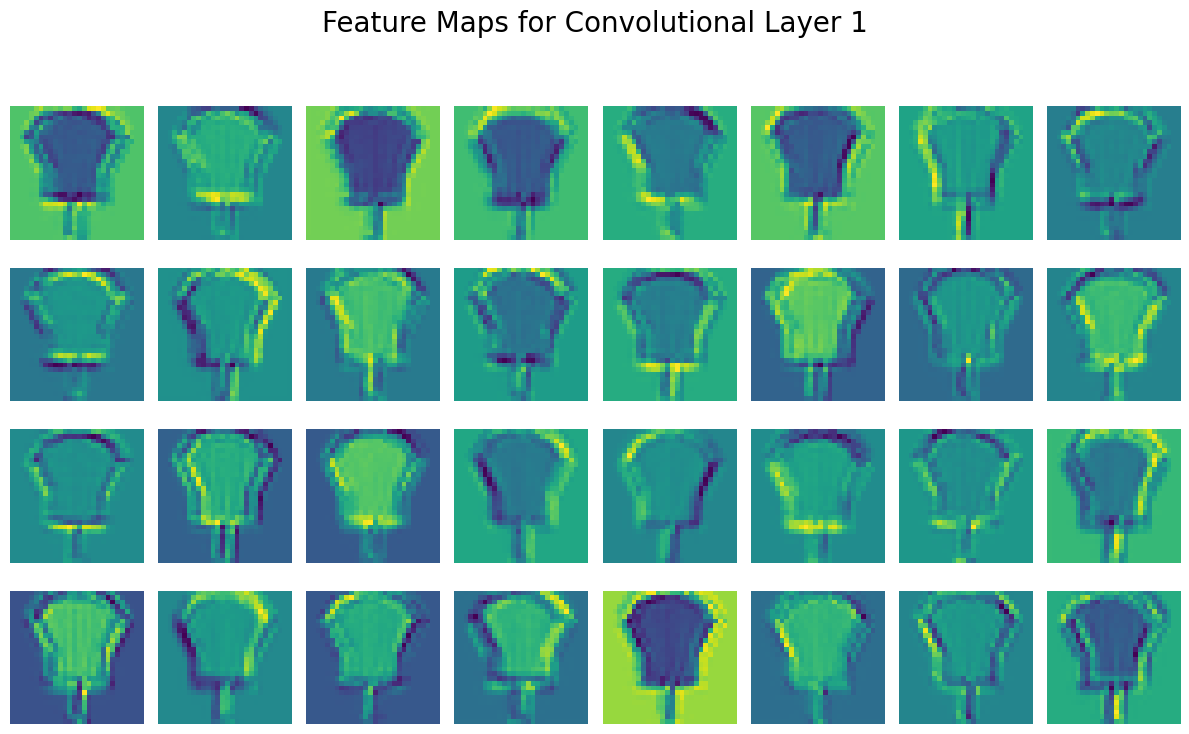

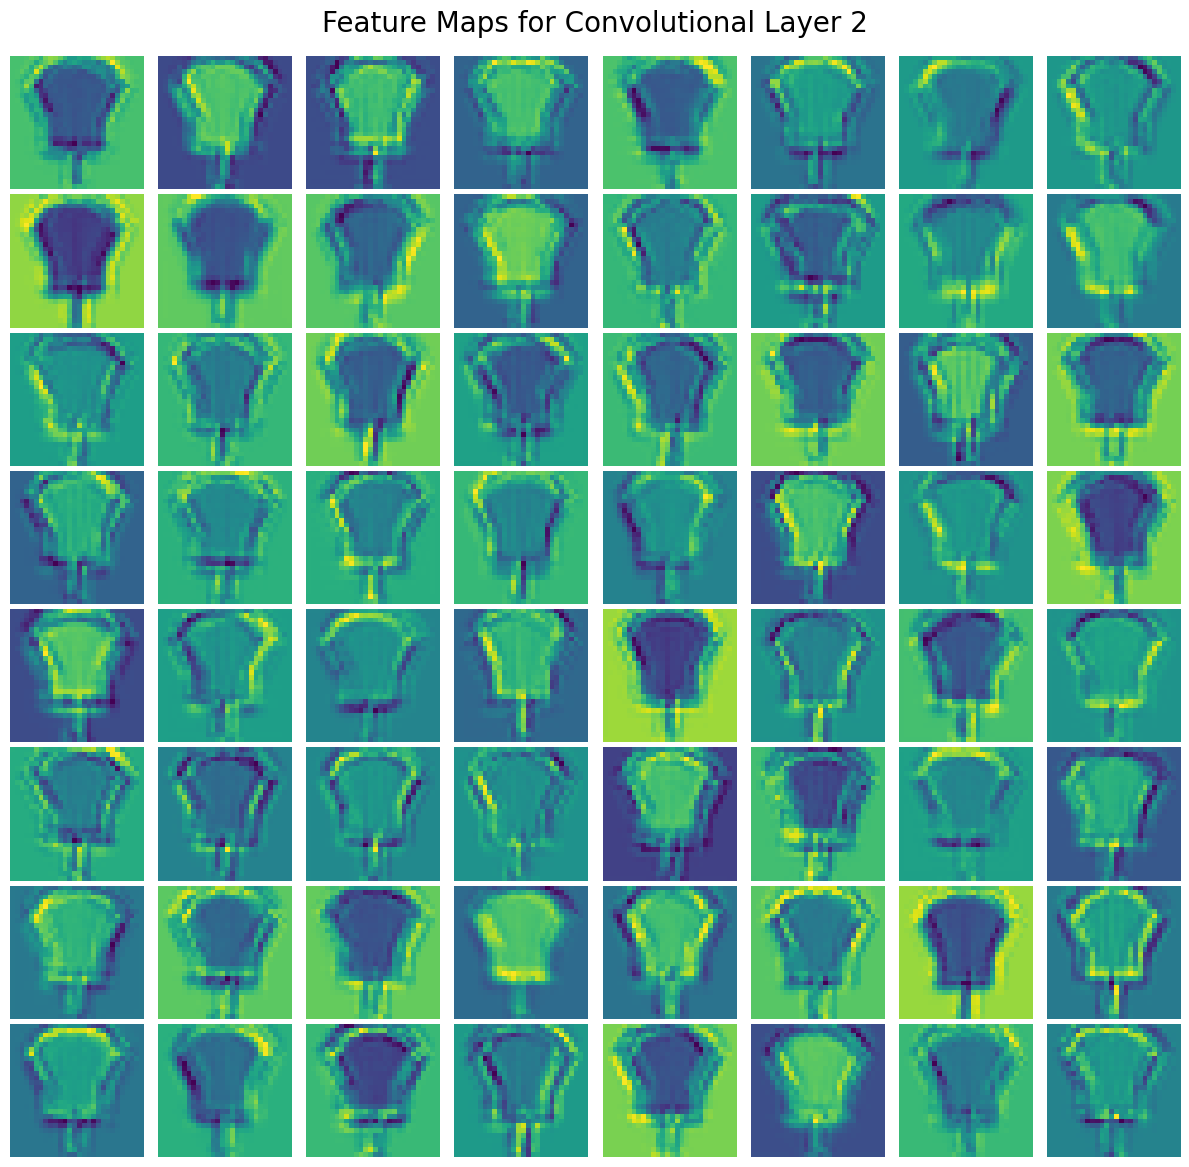

In [135]:
feature_maps_viz_runner(
    models[1],
    train_dataset.data[56],
    save_feature_maps=False,
    cmap="viridis",
)

In [136]:
# TODO: This is something for filtering experiments on certain things



# def model_arch_filter(x: pd.DataFrame, desired_arch: list[int]) -> pd.Series:
#     return x["model_architecture"] == desired_arch

# experiment_results_df.apply(model_arch_filter, axis=1, args=([1024, 512, 10],))

# no_batch_norm_rand_normal_mask = (
#     experiment_results_df["batch_normalization"]
#     & (experiment_results_df["weight_init"] == "xavier_uniform")
#     & (experiment_results_df["optimizer"] == "Adam")
#     # & (experiment_results_df["learning_rate"] == 0.01)
#     & (experiment_results_df["num_epochs"] == 30)
#     & experiment_results_df.apply(model_arch_filter, axis=1, args=([1024, 256, 10],))
# )
# no_batch_norm_rand_normal_mask.sum()

# experiment_results_df[no_batch_norm_rand_normal_mask]

In [138]:
# exps = experiment_results_df[no_batch_norm_rand_normal_mask].index.tolist()
# model_metadata_list = gather_metadata(
#     exps
# )

# plot_model_results(
#     model_metadata_list,
#     exps,
#     savefig=True,
# )

In [137]:
# experiment_subset_mask = (
#     (experiment_results_df["num_epochs"] == 30) &
#     (experiment_results_df["batch_normalization"] == True) &
#     (experiment_results_df["model_architecture"].apply(lambda x: tuple(x)) == (1024, 256, 10)) &
#     (experiment_results_df["optimizer"] == "Adam")
# )

# experiment_results_df[experiment_subset_mask]